<a href="https://colab.research.google.com/github/DajeanArcila/biblioteca_pandas/blob/main/Series_Temporais_Temperatura_sarimax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt


from statsmodels.tsa.arima.model import ARIMA

In [ ]:
!pip install scipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pmdarima.arima import auto_arima

In [ ]:
# vamos importar a base de produção de energia elétrica
df = pd.read_excel('temperature.xlsx', index_col='Date', parse_dates=True)
df.head()

,Daily minimum temperatures
Date,
1981-01-01,21
1981-02-01,18
1981-03-01,19
1981-04-01,15
1981-05-01,16


In [ ]:
df
#aqui comienza para ver si los datos estan bien y que el divisor de fecha sea igual, en este caso se tira el / y se coloca todo de una forma para que en la prediccion salga bien

In [ ]:
# Convertendo valores com "/" em datetime
mask = df['Date'].str.contains('/').fillna(False)
df.loc[mask, 'Date'] = pd.to_datetime(df.loc[mask, 'Date'], format='%m/%d/%Y')

# Convertendo a coluna inteira em datetime
df['Date'] = pd.to_datetime(df['Date'])

In [ ]:
df.dtypes
#aqui finaliza y continuamos normal con el codigo

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3647 entries, 1981-01-01 00:00:00 to 12/31/1990
Data columns (total 1 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   Daily minimum temperatures  3647 non-null   int64
dtypes: int64(1)
memory usage: 57.0+ KB


In [ ]:

df['Daily minimum temperatures'] = df['Daily minimum temperatures'].astype(float)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3647 entries, 1981-01-01 to 1990-12-31
Data columns (total 1 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Daily minimum temperatures  3647 non-null   float64
dtypes: float64(1)
memory usage: 57.0 KB


In [ ]:
df.head

,Date,Daily minimum temperatures
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


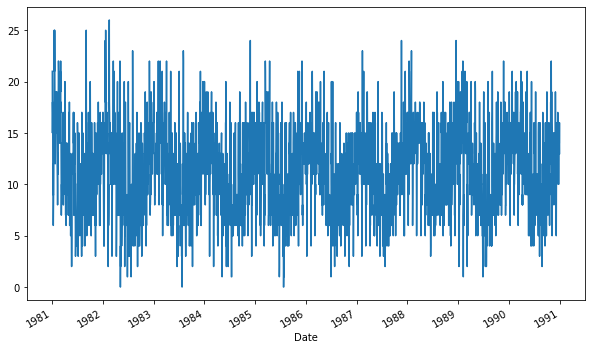

In [ ]:
df['Daily minimum temperatures'].plot(figsize=(10,6))

In [ ]:
df.head()

,Daily minimum temperatures
Date,
1981-01-01,21.0
1981-02-01,18.0
1981-03-01,19.0
1981-04-01,15.0
1981-05-01,16.0


In [ ]:
df.index.min(), df.index.max()

(Timestamp('1981-01-01 00:00:00'), Timestamp('1990-12-31 00:00:00'))

In [ ]:
df.sort_index(inplace=True)

<Figure size 576x432 with 0 Axes>

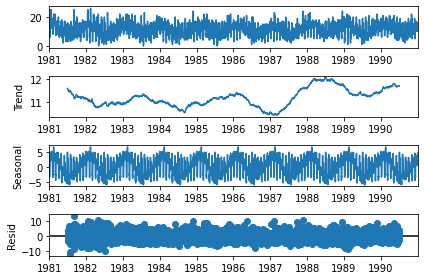

In [ ]:
# Primeiro, vamos decompor a série pra avaliar tendência
# Sazonalidade e resíduo
from statsmodels.tsa.seasonal import seasonal_decompose

resultado = seasonal_decompose(df, model="add",period=365)

fig = plt.figure(figsize=(8, 6))
fig = resultado.plot()

In [ ]:
# Teste de estacionariedade.
# A hipótese nula é que a série não é estacionária
# Ou seja, se o p-valor for menor que 0,05, rejeitamos
# que a série não é estacionária. Caso seja maior, não podemos
# descartar que a série não é estacionária
from statsmodels.tsa.stattools import adfuller

result=adfuller(df['Daily minimum temperatures'].dropna())
print(f'Teste ADF:{result[0]}')
print(f'p-valor:{result[1]}')

Teste ADF:-3.339747444319624
p-valor:0.013192595054305433


In [ ]:
# Auto ARIMA nos ajuda a buscar os melhores parâmetros
fit_arima = auto_arima(df, d=1, start_p=1, start_q=1, max_p=3, max_q=3,
                    seasonal=True,
                           m=6,
                           D=1,
                           start_P=1,
                           start_Q=1,
                           max_P=2,
                           max_Q=2,
                           information_criterion='aic',
                           trace=True,
                           error_action='ignore',
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[6]             : AIC=inf, Time=16.26 sec
 ARIMA(0,1,0)(0,1,0)[6]             : AIC=22243.431, Time=0.12 sec
 ARIMA(1,1,0)(1,1,0)[6]             : AIC=20987.996, Time=0.71 sec
 ARIMA(0,1,1)(0,1,1)[6]             : AIC=inf, Time=4.68 sec
 ARIMA(1,1,0)(0,1,0)[6]             : AIC=22092.231, Time=0.14 sec
 ARIMA(1,1,0)(2,1,0)[6]             : AIC=20491.077, Time=1.06 sec
 ARIMA(1,1,0)(2,1,1)[6]             : AIC=inf, Time=10.13 sec
 ARIMA(1,1,0)(1,1,1)[6]             : AIC=inf, Time=5.64 sec
 ARIMA(0,1,0)(2,1,0)[6]             : AIC=20678.596, Time=0.86 sec
 ARIMA(2,1,0)(2,1,0)[6]             : AIC=20426.987, Time=1.78 sec
 ARIMA(2,1,0)(1,1,0)[6]             : AIC=20935.695, Time=1.08 sec
 ARIMA(2,1,0)(2,1,1)[6]             : AIC=inf, Time=19.35 sec
 ARIMA(2,1,0)(1,1,1)[6]             : AIC=inf, Time=9.01 sec
 ARIMA(3,1,0)(2,1,0)[6]             : AIC=20361.477, Time=2.21 sec
 ARIMA(3,1,0)(1,1,0)[6]             : AIC=20882.212,

In [ ]:
# Agora que sabemos os melhores parâmetros, vamos criar um modelo SARIMAX
# (versão do arima com parametros para sazonalidade)

from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(df,order=(3,1,0))
resultado_sarimax = model.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [ ]:
# resultados do modelo SARIMAX(3,1,0)
resultado_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   SARIMAX Results                                    
======================================================================================
Dep. Variable:     Daily minimum temperatures   No. Observations:                 3647
Model:                       SARIMAX(3, 1, 0)   Log Likelihood               -9619.229
Date:                        Wed, 19 Oct 2022   AIC                          19246.457
Time:                                19:53:19   BIC                          19271.263
Sample:                                     0   HQIC                         19255.292
                                       - 3647                                         
Covariance Type:                          opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2950      0.015    -19.506      0.000      -0.325      -0.265
ar.L2         -0.1727      0.015    -11.272      0.000      -0.203      -0.143
ar.L3         -0.1207      0.016     -7.622      0.000      -0.152      -0.090
sigma2        11.4575      0.226     50.641      0.000      11.014      11.901
===================================================================================
Ljung-Box (L1) (Q):                   0.75   Jarque-Bera (JB):               106.76
Prob(Q):                              0.39   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                             0.01
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# Vamos realizar um "backtesting" com predições de valores dos 12 meses anteriores
predicoes = resultado_sarimax.get_prediction(start=-60)
predicao_media = predicoes.predicted_mean

In [ ]:
# intervalo de confiança

intervalo_confianca = predicoes.conf_int()
limites_abaixo = intervalo_confianca.iloc[:,0]
limites_acima = intervalo_confianca.iloc[:,1]

limites_abaixo[0], limites_acima[0]

(13.18006602789296, 26.44863056542449)

In [ ]:
predicao_media[0]

19.814348296658725

In [ ]:
datas_previsao = np.asarray(predicao_media.index)
datas = np.asarray(df.index)

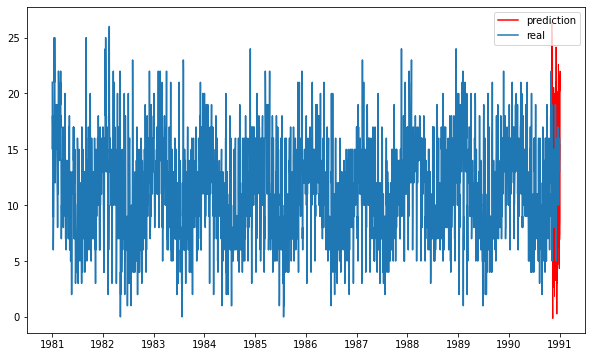

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(datas_previsao,predicao_media.values,color='red',label='prediction')
plt.fill_between(datas_previsao, limites_abaixo, limites_acima, color='red')
plt.plot(datas, df.values, label='real')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse_sarima = sqrt(mean_squared_error(df[-60:].values,predicao_media.values))
print(rmse_sarima)

3.0801017895800102


## Prevendo com XGBoost

In [ ]:
from xgboost import XGBRegressor

In [ ]:
treino = df.loc[df.index <= '1988-12-31']
validacao = df.loc[df.index > '1989-01-01']

treino.shape, validacao.shape

((2917, 1), (729, 1))

In [ ]:
treino.index.min(), treino.index.max()

(Timestamp('1981-01-01 00:00:00'), Timestamp('1988-12-30 00:00:00'))

In [ ]:
validacao.index.min(), validacao.index.max()

(Timestamp('1989-01-02 00:00:00'), Timestamp('1990-12-31 00:00:00'))

In [ ]:
treino['Daily minimum temperatures']

Date
1981-01-01    21.0
1981-01-02    15.0
1981-01-03    18.0
1981-01-04    17.0
1981-01-05     9.0
              ... 
1988-12-26    10.0
1988-12-27    13.0
1988-12-28    13.0
1988-12-29    15.0
1988-12-30    14.0
Name: Daily minimum temperatures, Length: 2917, dtype: float64

In [ ]:
treino['Daily minimum temperatures'].shift(-1)

Date
1981-01-01    15.0
1981-01-02    18.0
1981-01-03    17.0
1981-01-04     9.0
1981-01-05    12.0
              ... 
1988-12-26    13.0
1988-12-27    13.0
1988-12-28    15.0
1988-12-29    14.0
1988-12-30     NaN
Name: Daily minimum temperatures, Length: 2917, dtype: float64

In [ ]:
treino['target'] = treino['Daily minimum temperatures'].shift(-1)
treino.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Daily minimum temperatures,target
Date,,
1981-01-01,21.0,15.0
1981-01-02,15.0,18.0
1981-01-03,18.0,17.0
1981-01-04,17.0,9.0
1981-01-05,9.0,12.0


In [ ]:
treino.tail()

,Daily minimum temperatures,target
Date,,
1988-12-26,10.0,13.0
1988-12-27,13.0,13.0
1988-12-28,13.0,15.0
1988-12-29,15.0,14.0
1988-12-30,14.0,NaN


In [ ]:
treino = treino.dropna()
treino.tail()

,Daily minimum temperatures,target
Date,,
1988-12-25,16.0,10.0
1988-12-26,10.0,13.0
1988-12-27,13.0,13.0
1988-12-28,13.0,15.0
1988-12-29,15.0,14.0


In [ ]:
validacao['target'] = validacao['Daily minimum temperatures'].shift(-1)
validacao.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Daily minimum temperatures,target
Date,,
1989-01-02,16.0,20.0
1989-01-03,20.0,13.0
1989-01-04,13.0,14.0
1989-01-05,14.0,2.0
1989-01-06,2.0,6.0


In [ ]:
validacao.tail()

,Daily minimum temperatures,target
Date,,
1990-12-27,14.0,14.0
1990-12-28,14.0,14.0
1990-12-29,14.0,16.0
1990-12-30,16.0,13.0
1990-12-31,13.0,NaN


In [ ]:
validacao = validacao.dropna()
validacao.tail()

,Daily minimum temperatures,target
Date,,
1990-12-26,15.0,14.0
1990-12-27,14.0,14.0
1990-12-28,14.0,14.0
1990-12-29,14.0,16.0
1990-12-30,16.0,13.0


In [ ]:
X_treino = treino.loc[:, ['Daily minimum temperatures']].values
y_treino = treino.loc[:, ['target']].values
X_validacao = validacao.loc[:, ['Daily minimum temperatures']].values
y_validacao = validacao.loc[:, ['target']].values

X_treino.shape, y_treino.shape, X_validacao.shape, y_validacao.shape

((2916, 1), (2916, 1), (728, 1), (728, 1))

In [ ]:
modelo_xgba = XGBRegressor(objective="reg:squarederror", n_estimators=1000)
modelo_xgba.fit(X_treino, y_treino)

XGBRegressor(n_estimators=1000, objective='reg:squarederror')

In [ ]:
validacao.iloc[0]

Daily minimum temperatures    16.0
target                        20.0
Name: 1989-01-02 00:00:00, dtype: float64

In [ ]:
predicao = modelo_xgba.predict(X_validacao)
predicao

array([14.402495 , 15.040559 , 12.444436 , 13.360965 ,  6.687055 ,
        8.299292 ,  7.083378 ,  9.80238  , 10.831615 ,  8.946441 ,
       14.402495 , 11.665335 , 12.444436 , 14.902863 , 16.535097 ,
       14.902863 , 13.360965 , 12.444436 , 14.402495 , 13.556136 ,
       13.556136 , 12.444436 , 12.444436 , 13.556136 , 14.402495 ,
       14.902863 , 15.040559 , 16.363571 , 14.902863 , 14.902863 ,
       14.902863 , 13.360965 , 17.249796 , 13.556136 , 13.556136 ,
        5.4001374,  8.634034 ,  8.946441 ,  9.80238  ,  8.299292 ,
       10.197084 , 15.50876  , 15.50876  , 15.50876  , 16.535097 ,
       16.535097 , 15.040559 , 16.363571 , 14.402495 , 13.556136 ,
       14.402495 , 13.360965 , 12.444436 , 14.402495 , 15.50876  ,
       12.444436 , 14.402495 , 16.535097 , 16.535097 , 14.402495 ,
       15.040559 , 13.360965 , 11.665335 ,  6.687055 , 10.197084 ,
        8.946441 ,  8.299292 ,  7.450583 ,  9.80238  , 13.360965 ,
       12.444436 , 13.556136 , 13.556136 , 13.556136 , 11.6653

In [ ]:
validacao["pred"] = predicao
validacao.head()

,Daily minimum temperatures,target,pred
Date,,,
1989-01-02,16.0,20.0,14.402495
1989-01-03,20.0,13.0,15.040559
1989-01-04,13.0,14.0,12.444436
1989-01-05,14.0,2.0,13.360965
1989-01-06,2.0,6.0,6.687055


In [ ]:
mean_squared_error(X_validacao, predicao)

2.663103052558342